# Apprendimento Supervisionato

## Sommario 

La rappresentazione tramite modello NDOM discussa nella sezione precedente ci ha permesso, di fatto, di ingegnerizzare e aggiungere al DS iniziale 8 nuove feature, `task1`, `task2`, ..., `task8`.
In questa sezione costruiamo e valutiamo dei modelli di apprendimento supervisionato (SL) che eseguono un task di regressione, cioè predizione del valore della feature target `metric` avente dominio continuo.

## Strumenti utilizzati

Da una prima osservazione del numero di elementi del DS, possiamo concludere che non sarebbe conveniente implementare un modello complesso come un'ANN. I modelli costruiti in seguito sono modelli classici implementati tramite libreria [scikit-learn](https://scikit-learn.org/stable/modules/classes.html). Le operazioni più elementari su Dataset, matrici e array vengono fatte tramite [pandas](https://pandas.pydata.org/) e [numpy](https://numpy.org/).

Prima però, bisogna effettuare una prima fase di Preprocessing e osservazione del DS.

## Preprocessing del DS

### Caricamento del DS e Feature Selection

Innanzitutto, una prima osservazione da fare è che il DS che utilizzeremo per l'addestramento dei modelli non comprende la feature `page_ungrouped_multim` e `page_menu_or`. Ricordiamo che queste due feature sono dei fattori di decisione che l'utente considera osservando direttamente la pagina e che si ritengono non osservabili a partire dal solo codice sorgente. Discorso diverso vale per la feature `page_template` per la quale in questo progetto si assume che possa essere comunque estratta automaticamente a partire dal codice sorgente della pagina. Nella sezione del NDOM, per semplicità, l'utente lo inseriva manualmente piuttosto che ricavarla automaticamente. In futuro, questa operazione può essere automatizzata analizzando le risorse esterne (fogli di stile, codice JS, ...) che la pagina scarica dal server web.

Un ultima considerazione riguarda il fatto che in questa sezione assumiamo, salvo diversamente specificato, che i parametri del NDOM (discussi nella precedente sezione *Decisioni di Progetto*) siano quelli di default.


In [1]:
import agent.definitions as defs
import pandas as pd

df = pd.read_csv(defs.ds3_gt_final_path)

ds3_features_pk = ["school_id", "page_url"]
ds3_features_part1 = ["page_menu_or", "page_ungrouped_multim"] # osservate manualmente
ds3_features_part2 = [ # osservate automaticamente
    "page_template",
    "page_load_time_ms",
    "page_width",
    "page_height",
    "NDOM_nodes",
    "NDOM_height",
]
ds3_features_part3 = ["task1", "task2", "task3", "task4", "task5", "task6", "task7", "task8"]
ds3_target = "metric"

# features
ds3_features = (
    ds3_features_pk + ds3_features_part1 + ds3_features_part2 + ds3_features_part3
)
ds3_features.append(ds3_target)

# >>>
df.head(3)

,school_id,page_url,page_load_time_ms,page_width,page_height,NDOM_nodes,NDOM_height,page_template,page_menu_or,page_ungrouped_multim,metric,task1,task2,task3,task4,task5,task6,task7,task8
0,CBSL00201A,https://www.liceopagano.edu.it,516,1604,848,1,0,9.0,2.0,6.0,2.9,6.50,6.50,6.50,6.5,6.50,6.5,6.50,6.50
1,RGTD03002X,https://www.itcbesta.edu.it,1278,1587,2441,162,7,6.0,1.0,8.0,3.7,1.37,2.10,2.75,6.5,2.10,5.6,3.83,6.50
2,CSPS07301E,https://www.iismarconiguarasci.edu.it/,1006,1587,2533,348,3,3.0,3.0,10.0,4.0,1.30,1.65,3.07,3.3,1.92,0.3,6.50,2.51


### Rilevazione rumore nel DS

In questa sezione andiamo a rilevare eventuali valori del DS che non rientrano nel dominio della feature associata. Conoscendo il dominio teorico di ciascuna feature, li rappresentiamo tutti in forma interpretabile del linguaggio Python, mediante un dizionario: i domini discreti sono il tipo `str` o una lista; i domini continui sono delle funzioni lambda.   

In [2]:
# estremi dei domini di alcune feature
PAGE_TEMPLATE_MIN_VAL = 1
PAGE_TEMPLATE_MAX_VAL = 9

PAGE_MENU_OR_MIN_VAL = 0
PAGE_MENU_OR_MAX_VAL = 3

METRIC_MIN_VAL = 1
METRIC_MAX_VAL = 5

# domini feature. un dominio può essere un tipo, una lista
# o una funzione lambda (per domini infiniti, cioè per features continue)
ds3_gt_feature_domains = {
    "school_id": str,
    "page_url": str,
    "page_template": [x for x in range(PAGE_TEMPLATE_MIN_VAL, PAGE_TEMPLATE_MAX_VAL + 1)],
    "page_menu_or": [x for x in range(PAGE_MENU_OR_MIN_VAL, PAGE_MENU_OR_MAX_VAL + 1)],
    "page_ungrouped_multim": lambda v: v >= 0 and v % 1 == 0, # numero naturale
    "metric": lambda v: v >= METRIC_MIN_VAL and v <= METRIC_MAX_VAL,
    "page_load_time_ms": lambda v: v >= 0,
    "page_width": lambda v: v >= 0,
    "page_height": lambda v: v >= 0,
    "NDOM_nodes": lambda v: v >= 0 and v % 1 == 0,
    "NDOM_height": lambda v: v >= 0 and v % 1 == 0,
    "task1": lambda v: v >= 0,
    "task2": lambda v: v >= 0,
    "task3": lambda v: v >= 0,
    "task4": lambda v: v >= 0,
    "task5": lambda v: v >= 0,
    "task6": lambda v: v >= 0,
    "task7": lambda v: v >= 0,
    "task8": lambda v: v >= 0,
}
# altra rappresentazione possibile del dominio di metric
#"metric": [
#    x / 10
#    for x in range((1 * 10), (5 * 10 + int(0.1 * 10)))
#],


def get_features_types(feature_domains: dict):
    """Restituisce le features discrete e continue.

    Args:
        - features_domains: Dizionario feature:dominio che rispetta la sintassi espressa sopra.

    Returns:
        - features_d: Lista di features discrete.
        - features_c: Lista di features continue.
    """

    features_d = []
    features_c = []

    for feature, domain in feature_domains.items():
        if (isinstance(domain, list)): # or (domain is str)
            features_d.append(feature)
        elif callable(domain) and isinstance(domain, type(lambda x: x)):
            features_c.append(feature)
        else:
            pass

    return features_d, features_c

# >>>
features_discrete, features_continuous = get_features_types(ds3_gt_feature_domains)
print(f"Discrete: {features_discrete}")
print(f"Continuous: {features_continuous}")


Discrete: ['page_template', 'page_menu_or']
Continuous: ['page_ungrouped_multim', 'metric', 'page_load_time_ms', 'page_width', 'page_height', 'NDOM_nodes', 'NDOM_height', 'task1', 'task2', 'task3', 'task4', 'task5', 'task6', 'task7', 'task8']


Controlliamo il modo in cui le feature sono rappresentate all'interno DS.

In [3]:
df.dtypes

school_id                 object
page_url                  object
page_load_time_ms          int64
page_width                 int64
page_height                int64
NDOM_nodes                 int64
NDOM_height                int64
page_template            float64
page_menu_or             float64
page_ungrouped_multim    float64
metric                   float64
task1                    float64
task2                    float64
task3                    float64
task4                    float64
task5                    float64
task6                    float64
task7                    float64
task8                    float64
dtype: object

Come possiamo vedere, tutte le feature  discrete (`page_template`, `page_menu_or`) sono già rappresentate in forma numerica, per cui non c'è bisogno di usare nessuno degli [Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) previsti dalla libreria scikit-learn. Piuttosto, facciamo in modo che le feature discrete vengano rappresentate  da numeri `int64` e non da `float64`.

In [4]:
import numpy as np

float64 = np.dtype('float64')

for feature_d in features_discrete:
    if df[feature_d].dtype is float64:
        df[feature_d] = df[feature_d].astype(np.int64)

# >>>
df.dtypes

school_id                 object
page_url                  object
page_load_time_ms          int64
page_width                 int64
page_height                int64
NDOM_nodes                 int64
NDOM_height                int64
page_template              int64
page_menu_or               int64
page_ungrouped_multim    float64
metric                   float64
task1                    float64
task2                    float64
task3                    float64
task4                    float64
task5                    float64
task6                    float64
task7                    float64
task8                    float64
dtype: object

Controlliamo se esistono valori del DS che non rietrano nei rispettivi domini.

In [5]:
from pandas import DataFrame

def is_in_feature_domain(domain, value) -> bool:
    """Dato il dominio di una feature, restituisce True se value compare nel dominio,
    False altrimenti.

    Args:
        - domain: Dominio di una feature. Può essere un tipo (es. str), una lista o una funzione lambda.
        - value: Valore da controllare.
    """

    if domain is str:
        return isinstance(value, str)

    elif isinstance(domain, list):
        return value in domain

    elif callable(domain) and isinstance(domain, type(lambda x: x)):
        return domain(value)

    else:
        return False


def detect_noisy_rows_values(df: DataFrame, domains: dict):
    """Rileva quali sono le righe del DS df in cui almeno una feature non è corretta,
    cioè non rientra nel suo dominio.

    Args:
        - df: Istanza Dataframe.
        - ds_feature_domains: Dizionario feature:funzione di validazione.

    Returns:
        - noisy_rows: Righe in cui esiste almeno una colonna con valori errati.
        - noisy_cols: Colonne i cui valori in corrispondenza sono errati.
    """

    print("Detecting noisy rows...")
    noisy_rows = set()
    noisy_cols = set()

    for column in list(domains.keys()):
        serie = df[column]

        for i, el in serie.items():
            if not is_in_feature_domain(domains[column], el):
                noisy_rows.add(i)
                noisy_cols.add(df.columns.get_loc(column))

    if noisy_rows:
        print(f"{len(noisy_rows)} noisy row(s) exist! Please check them.")
    else:
        print("No noisy rows exist.")

    return list(noisy_rows), list(noisy_cols)


# >>>
noisy_rows, noisy_cols = detect_noisy_rows_values(df, ds3_gt_feature_domains)

if noisy_rows:
  print(df.iloc[noisy_rows, noisy_cols])

Detecting noisy rows...
3 noisy row(s) exist! Please check them.
     page_menu_or  page_ungrouped_multim
805             2                    4.2
924            11                   24.0
701             6                    6.0


Ri-effetuiamo la valutazione per i siti che compaiono in questa lista e inseriamole in un nuovo DS.

In [6]:
ds = pd.read_csv(defs.ds3_gt_no_noise_path)

# >>>
noisy_rows, noisy_cols = detect_noisy_rows_values(ds, ds3_gt_feature_domains)

if noisy_rows:
  print(ds.iloc[noisy_rows, noisy_cols])

Detecting noisy rows...
No noisy rows exist.


### Panoramica distribuzione valori e Feature Correlation

Fino ad ora siamo giunti alla creazione del DS finale da usare per i modelli, ma non abbiamo ancora dato uno sguardo alla popolarità dei valori dei domini delle variabili. Per cui generiamo gli istogrammi indicanti la distribuzione dei dati.

Text(0.5, 0.98, 'Distribution for each feature domain value')

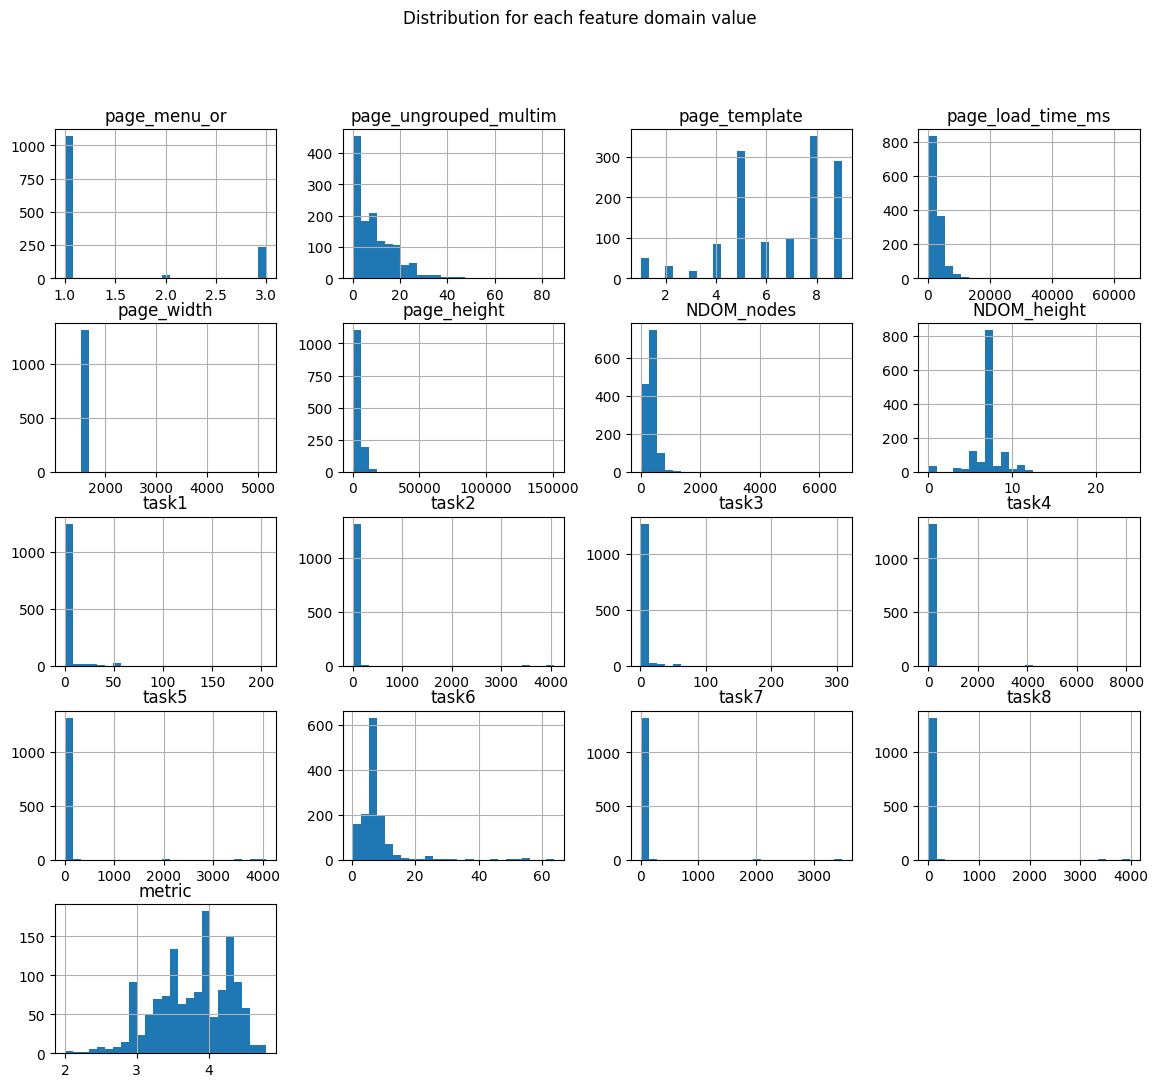

In [7]:
import matplotlib.pyplot as plt

hist_columns = ds3_features_part1 + ds3_features_part2 + ds3_features_part3
hist_columns.append(ds3_target)

# >>>
ds.hist(column=hist_columns, figsize=(14,12), bins=25)
plt.suptitle("Distribution for each feature domain value")

Facciamo alcune osservazioni:
- I template più popolari sono senza dubbio il #5 e #8, anche se c'è una buona quantità di siti che non seguono un modello vero e proprio (#9).
- Riguardo all'orientamento dei menu, ~94% di siti presentano un menu orizzontale. ~20% di questi hanno anche un menu verticale.
- Riguardo il numero di elementi multimediali non raggruppati, le pagine confermano il trend (se vogliamo negativo) di banner e/o video sparsi senza criterio sulla pagina: solo il ~19% ne presenta 0, tutti i restanti ne hanno almeno uno.
- Per l'istogramma relativo alla metrica notiamo che la scala verticale si ferma a poco meno di 200, per cui non c'è un valore del dominio di `metric` che "monopolizza" il DS.
- In generale, tutte le features continue mostrate nel grafico non seguono una distribuzione normale. 

Di seguito è anche possibile visualizzare la correlazione che c'è tra ciascuna feature, e più in particolare, è di nostro interesse la misura con cui ciascuna input feature incide sulla feature target `metric`. Ne traiamo le seguenti osservazioni:
- Nel quadrante in basso a destra si nota una correlazione diretta (positiva) tra le feature `taskx`. Il motivo potrebbe essere che, poichè i task dipendono tutti dalla struttura della pagina e dalla struttura dei menu, se l'utente fatica a trovare un certo task (ad es. il Regolamento di Istituto, che è il `task2`), faticherà anche a trovare i task simili (l'organigramma scolastico, che è il `task5` ed è un task più o meno inerente al Regolamento.)
- Il quadrato blu indica una correlazione alta (ma comunque < -1) e inversa tra `metric` e `page_ungrouped_multim`: aumentano gli elementi multimediali confusionari, diminuisce la valutazione.

Ovviamente questa Feature Heatmap non può generalizzare troppo, è da ritenersi come una semplice rappresentazione grafica del GT. 

<Axes: >

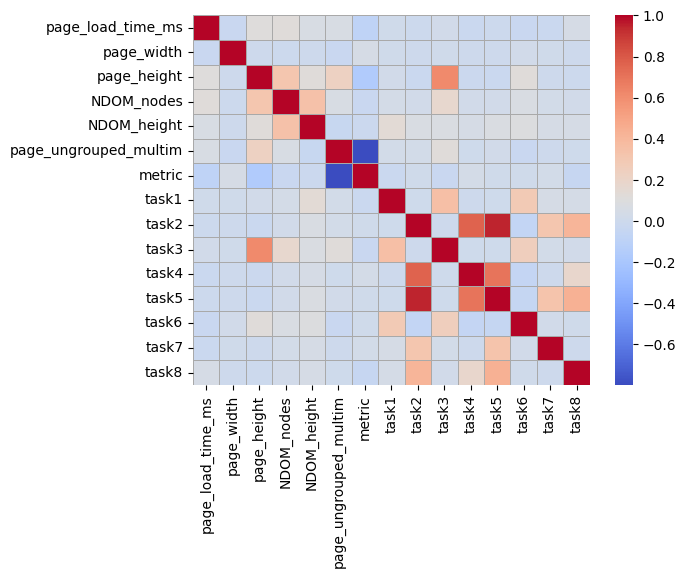

In [8]:
import seaborn as sns

ds_correlation = ds.drop(ds3_features_pk+features_discrete, axis=1).corr(method="pearson")
sns.heatmap(ds_correlation, linewidths=0.5, linecolor='darkgray', cmap="coolwarm")

## Modelli di regressione e decisioni di progetto

In questa sezione cerchiamo il/i modello/i che si avvicina di più al Ground Truth, mettendoli tutti su una stessa scala di giudizio, ovvero le metriche di misurazione degli errori.

A causa numero piuttosto limitati di esempi del DS, assumiamo che le metriche di un qualsiasi modello devono essere calcolate facendo in modo che il modello possa sfruttare i dati dell'intero DS. Per questo motivo, possiamo dire che la tecnica di [k-fold Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) verrà impiegata in due casistiche:
- vogliamo ottenere delle metriche di errore affidabili per un determinato modello, magari quando sappiamo a priori una certa configurazione di iperparametri. Solamente in questo caso la CV genera k Split, cioè k modalità di utilizzo **di tutto il DS**.
- vogliamo trovare una configurazione ottimale di iperparametri per un determinato modello. In questo caso, dobbiamo prima nascondere il TE dai modelli e in seguito applicare la CV usando i dati del TS.

Di seguito andiamo a creare `X` (DS ridotto alle sole feature di input) e `y` (DS ridotto alla feature target `metric`). Successivamente, dividiamo il DS in TS e TE secondo il rapporto 8:2.

In [9]:
from sklearn.model_selection import train_test_split

# dataset-------
ds3_features_excluded = ds3_features_pk + ds3_features_part1
ds3_features_excluded.append(ds3_target)

# X (tabella con colonne input feature) e y (tabella target)
X_DS = ds.drop(ds3_features_excluded, axis=1)
y_DS = ds[ds3_target]

# anche in forma di ndarray per numpy
X_DS_ = X_DS.to_numpy()
y_DS_ = y_DS.to_numpy()

# TS e TE-------
X_TS, X_TE, gt_y_TS, gt_y_TE = train_test_split(X_DS, y_DS, test_size=0.25, random_state=42)

# anche in forma di ndarray per numpy
X_TS_ = X_TS.to_numpy()
gt_y_TS_ = gt_y_TS.to_numpy()
X_TE_ = X_TE.to_numpy()
gt_y_TE_ = gt_y_TE.to_numpy()

### Regressore Lineare

Il regressore lineare utiizza il metodo dei minimi quadrati per calcolare i coefficienti di una retta di regressione. Non ci sono iperparametri da ottimizzare.

#### 1^ Costruzione (senza k-fold CV)

In [10]:
from sklearn.linear_model import LinearRegression

# modello
regLin = LinearRegression()
regLin.fit(X_TS, gt_y_TS)

# predizione
regLin_y_TS = regLin.predict(X_TS)
regLin_y_TE = regLin.predict(X_TE)

##### OSSERVAZIONE: Cambio categoria e penalità applicata all'errore

Dopo aver costruito il modello, diamo un'occhiata ai valori effettivi della feature target (nel TS) e le relative previsioni.

In [11]:
from pandas import Series
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# >>>
gt_y_TE # fisso
Series(regLin_y_TE) # fisso

0      4.236206
1      3.900177
2      4.026052
3      4.134113
4      3.546541
         ...   
328    3.963386
329    3.984144
330    3.526731
331    3.661345
332    3.661926
Length: 333, dtype: float64

Calcoliamo manualmente l'errore che otteniamo. Questa operazione sarà poi automatizzata, ma per il momento lo facciamo per avere una panoramica sulle percentuali di errore fatte dal modello.

In [12]:
regLin_err = np.subtract(regLin_y_TE, gt_y_TE) # fisso

# >>>
regLin_err

893     0.536206
115     0.500177
526    -0.373948
175    -0.665887
63      0.746541
          ...   
1326   -0.436614
1293   -0.315856
628     0.026731
1010    0.161345
178     0.161926
Name: metric, Length: 333, dtype: float64

Il calcolo "manuale" dell'errore che il modello fa sul target **di questo specifico TS** è stato fatto per poter vedere quante volte il modello fa una previsione che si discosta dal valore attuale di una certa percentuale. L'istogramma generato di seguito ha solo funzione informativa e solo in questa evenienza si è calcolato l'errore con segno. In seguito, quando si andrà a calcolare le metriche dei modelli, si useranno le metriche convenzionali di misurazione dell'errore.

Sull'asse X dell'istogramma ci sono le possibili percentuali di errore (da -100% a 100%) ad indicare il fatto che questo modello può fare una previsione con un errore percentuale negativo (il modello predice una valutazione minore della valutazione reale), uguale a 0, o positivo.
Ad es. un errore -100% si verifica quando il valore attuale di `metric` è 5 e il modello predice 1. In corrispondenza di una percentuale, sull'asse Y il grafico dice per quanti esempi del TS il modello fa una predizione con questo errore percentuale.

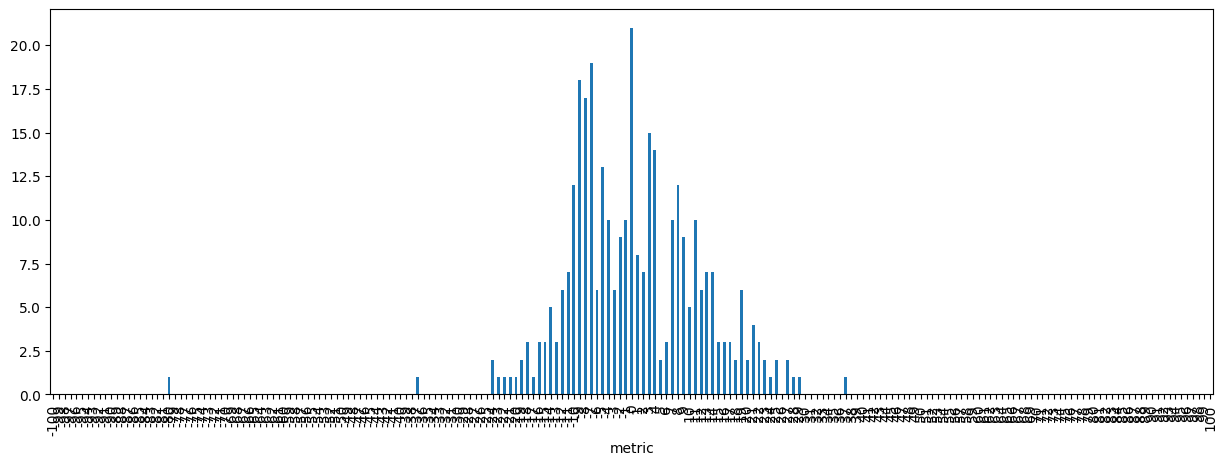

In [13]:
# conosciamo il valore di un ipotetico errore massimo
max_error = METRIC_MAX_VAL - METRIC_MIN_VAL

def calc_err_percentage(x):
    perc = float((x*100)/max_error)
    return int(perc)

def plot_err_perc(model_err:Series):
    # creo una nuova serie che associa ad ogni elemento la sua percentuale di errore
    model_err_perc = model_err.apply(calc_err_percentage)

    model_err_perc_count = model_err_perc.value_counts()
    model_err_perc_count = model_err_perc_count.reindex(range(-100, 101), fill_value=0)
    model_err_perc_count = model_err_perc_count.sort_index()

    # >>>
    model_err_perc_count.plot(kind='bar', figsize=(15,5))

plot_err_perc(regLin_err)

Il modello (sugli esempi di questo specifico TE) non fa errori molto gravi (vale a dire tanti errori minori del -50% o maggiori del 50%) ma possiamo fare una osservazione.

Consideriamo una pagina web per il quale la valutazione è 3.2. Se il modello fa un errore (anche piccolo) di -0.4 punti, si verifica un vero e proprio cambio categoria: il sito teoricamente è *Accettabile*, ma il modello lo classifica come *Confuso* (3.2-0.4=2.8). Situazione diversa si ha se il modello fa un errore (ancora piccolo) di 0.4 punti, e quindi il modello predice il valore 3.6, senza predire un cambio categoria.

**Sarebbe corretto in questa casistica parlare di errori equivalenti?** Si ipotizza di no, per cui si introduce un errore aggiuntivo che il modello compie qualora vada a cambiare una categoria. In altre parole, stiamo "forzando" i modelli che addestreremo a compiere un errore quanto più basso possibile soprattutto per le pagine la cui valutazione è a un'estremità (inferiore o superiore) della categoria corrente.

La penalità che calcoliamo viene definita con la funzione `calc_err_penalty` che si comporta nel seguente modo:
- se non c'è un cambio categoria, l'errore del modello non subisce una ulteriore penalità.
- se c'è un cambio categoria allora viene applicata la penalità, che dipende dal numero di categorie tra quella attuale e quella prevista. Eventualmente, possiamo anche prevedere delle penalità più severe se il modello predice una categoria peggiore rispetto a quella attuale (`page_category_shift` < 0)

Il comportamento di questa funzione è visibile da questo [grafico](https://www.desmos.com/calculator/5y734tuqft). Avremmo potuto implementare questa funzione con un semplice if-else, però il grafico (poichè non è simmetrico all'asse Y) evidenzia il fatto delle penalità più severe quando `page_category_shift` < 0. Infine, dobbiamo precisare che le penalità relative a quando `page_category_shift` < 0 devono avere segno negativo, altrimenti andrebbero contro il nostro intento. Per comodità, nel grafico, tutte le penalità hanno segno positivo.

In [14]:
def calc_err_penalty(y_gt, y_pred):
    """ Calcola la penalità da sommare all'errore qualora c'è un cambio categoria.

    Args:
        - y_gt: Target attuale.
        - y_pred: Target previsto dal modello (include un errore).
    """

    pred_category = int(y_pred) # positivo
    gt_category = int(y_gt) # positivo

    page_category_shift = pred_category - gt_category
    #page_category_shift può essere < 0 (modello predice categoria più bassa)
    # = 0 (stessa categoria)
    # > 0 (modello predice categoria più alta)

    if page_category_shift == 0:
        return y_pred

    elif (page_category_shift < 0 and gt_category <= METRIC_MIN_VAL) or \
        (page_category_shift > 0 and gt_category >= METRIC_MAX_VAL - 1):
        # c'è un cambio categoria ma non lo consideriamo tale
        return y_pred

    else:
        # calcolo penalty
        a = 0.006 #0.009
        b = -0.0008 #-0.0008
        c = 0.108 #0.009
        penalty = (((a)*(page_category_shift**2))+
                ((b)*page_category_shift)+
                (c)
        )
        if page_category_shift < 0:
            penalty = penalty*(-1)
        # ---

        err_category = int(y_pred + penalty) # positivo

        if pred_category == err_category:
            return y_pred + penalty

        # evito che la penalità sia eccessiva
        elif page_category_shift < 0:
            return y_pred + (pred_category - y_pred) #y_pred + (<0)
        else:
            #return y_pred + (penalty - (y_pred + penalty - err_category + 0.1))
            return y_pred + (err_category - y_pred - 0.1)

# vettorizza funzione
vcalc_err_penalty = np.vectorize(calc_err_penalty, otypes=[float])

Aggiorniamo le predizioni che il Regressore Lineare fa sul TE.

In [15]:
# >>>
print("Before applying error penalty.")
Series(regLin_y_TE) # before

regLin_y_TE = vcalc_err_penalty(gt_y_TE, regLin_y_TE)
regLin_y_TE = np.clip(regLin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)

print("After applying error penalty.")
Series(regLin_y_TE) # after

Before applying error penalty.


0      4.236206
1      3.900177
2      4.026052
3      4.134113
4      3.546541
         ...   
328    3.963386
329    3.984144
330    3.526731
331    3.661345
332    3.661926
Length: 333, dtype: float64

After applying error penalty.


0      4.349406
1      3.900177
2      4.026052
3      4.134113
4      3.659741
         ...   
328    3.848586
329    3.869344
330    3.526731
331    3.661345
332    3.661926
Length: 333, dtype: float64

#### 2^ Costruzione (con procedura di k-fold CV che include il calcolo delle penalità)

L'utilizzo della strategia di calcolo delle penalità implica il dover implementare manualmente una procedura di k-fold CV. Essa fa comunque un test sistematico degli iperparametri, come avviene nel [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Inoltre nella CV usiamo un numero di fold `k = 5`, che equivale a un rapporto TS:VS = 8:2. Con la CV possiamo ricavare delle metriche di performance che dipendono da **tutto il DS** e non da una singola parte.

I Regressori Lineari, poichè calcolano coefficienti di apprendimento mediante discesa di gradiente, sono sensibili al feature scaling. Con il feature scaling, infatti, l'algoritmo di discesa del gradiente converge più velocemente al minimo. In questo progetto usiamo un [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

In [16]:
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.base import RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def kfold_cv_w_err_penalty(X, y, m:RegressorMixin, m_name, param_grid:ParameterGrid, k, scaler:MinMaxScaler, plot_err=False):
    """Costruisce il modello m per il quale esistono iperparametri inseriti in param_grid.
    Per ciascuna configurazione di iperparametri, applica la k-fold CV usando i dati di X e y.
    Restituisce una lista di Dataframe, una per ogni configurazione di iperparametri.

    Args:
        - X: dati delle input feature.
        - y: dati della target feature.
        - m: modello di regressione.
        - m_name: Nome del modello.
        - param_grid (ParameterGrid). Oggetto contenente i domini degli iperparametri.
        - k: numero di folds.
        - scaler: oggetto MinMaxScaler.
    
    Returns:
        - model_perf: Un array di DataFrame (un DataFrame per ogni possibile combinazione di iperparametri)
    """

    # lista di possibili combinazioni di iperparametri
    param_combos = [' ']
    if param_grid is None or len(param_grid) == 0:
        param_exist = False
    else:
        param_combos = list(param_grid)
        param_exist = True

    # i dati vengono prima mescolati in modo casuale prima di essere suddivisi in test/training.
    kf_logic = KFold(n_splits=k, shuffle=True, random_state=77)

    # restituisco una lista di dataframe, uno per ogni combinazione di iperparametri
    model_perf = [DataFrame() for param_combo_id in param_combos]

    # itera sulle possibili configurazioni di iperparametri
    param_combo_id = 0
    for param_combo in param_combos:

        # Creo k split a partire da X e y.
        # X e y possono rappresentare l'intero DS, oppure il TS.
        # https://stats.stackexchange.com/questions/339736/perform-cross-validation-on-train-set-or-entire-data-set
        kf_splits = kf_logic.split(X=X, y=y)

        # itera sugli split
        split_no = 1
        for TS_idx, TE_idx in kf_splits:
            # considero l'i-esimo split (su 10).
            # questo split si compone da 9 folds per il TS (che in totale formano X_TS_fold e gt_y_TS_fold)
            # e 1 fold per il TE (anche chiamato Validation) (formata da X_TE_fold e gt_y_TE_fold).
            # man mano che si cicla su questo for, gli elementi del TS e TE cambiano

            X_TS_fold,    X_TE_fold    = X[TS_idx], X[TE_idx]
            gt_y_TS_fold, gt_y_TE_fold = y[TS_idx], y[TE_idx]

            # scaling (va fatto sempre dopo lo split)
            if scaler is not None:
                scaler.fit(X_TS_fold)
                X_TS_fold = scaler.transform(X_TS_fold)
                # https://stats.stackexchange.com/q/319514
                X_TE_fold = scaler.transform(X_TE_fold)
            
            # modello
            if param_exist:
                model = m.set_params(**param_combo)
            else:
                model = m
            model.fit(X_TS_fold, gt_y_TS_fold)

            # predizione
            model_y_TS_fold = model.predict(X_TS_fold)
            #model_y_TS_fold = vcalc_err_penalty(gt_y_TS_fold, model_y_TS_fold)
            model_y_TS_fold = np.clip(model_y_TS_fold, METRIC_MIN_VAL, METRIC_MAX_VAL)
            
            model_y_TE_fold = model.predict(X_TE_fold)
            #model_y_TE_fold = vcalc_err_penalty(gt_y_TE_fold, model_y_TE_fold)
            model_y_TE_fold = np.clip(model_y_TE_fold, METRIC_MIN_VAL, METRIC_MAX_VAL)

            # valutazione
            fold_index = f"{m_name} (Split {split_no})"

            model_perf[param_combo_id] = pd.concat(
                [
                    model_perf[param_combo_id],
                    pd.DataFrame([{
                            "MAE (TS)": mean_absolute_error(gt_y_TS_fold, model_y_TS_fold),
                            "MSE (TS)": mean_squared_error(gt_y_TS_fold, model_y_TS_fold),
                            "RMSE (TS)": mean_squared_error(gt_y_TS_fold, model_y_TS_fold, squared=False),
                            "MAPE (TS)": mean_absolute_error(gt_y_TS_fold, model_y_TS_fold),
                            "R^2 (TS)": r2_score(gt_y_TS_fold, model_y_TS_fold),

                            "MAE (TE)": mean_absolute_error(gt_y_TE_fold, model_y_TE_fold),
                            "MSE (TE)": mean_squared_error(gt_y_TE_fold, model_y_TE_fold),
                            "RMSE (TE)": mean_squared_error(gt_y_TE_fold, model_y_TE_fold, squared=False),
                            "MAPE (TE)": mean_absolute_error(gt_y_TE_fold, model_y_TE_fold),
                            "R^2 (TE)": r2_score(gt_y_TE_fold, model_y_TE_fold)
                        }], index=[fold_index]
                    )
                ],
                axis = 0
            )

            if plot_err and split_no == 2:
                plot_err_perc(model_err=Series(np.subtract(model_y_TE_fold, gt_y_TE_fold)))

            # vai al prossimo split
            split_no = split_no + 1

        # Aggiungi una nuova riga al fondo del DataFrame con le medie
        avg_index = f"Average ({str(param_combo)})" if param_exist else "Average"
        means = model_perf[param_combo_id].mean()

        model_perf[param_combo_id] = pd.concat(
            [
                model_perf[param_combo_id],
                pd.DataFrame(
                    [means], index=[avg_index], columns=means.index
                )
            ],
            axis = 0
        )

        param_combo_id = param_combo_id + 1

    return model_perf

Costruiamo il modello con la funzione appena scritta.

In [17]:
regLin_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=LinearRegression(),
                                    m_name="Linear Regressor",
                                    param_grid=None,
                                    k=5,
                                    scaler=MinMaxScaler())

# >>>
print(f"{len(regLin_perf)} model performance table(s) available.")
regLin_perf[0]

1 model performance table(s) available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
Linear Regressor (Split 1),0.363713,0.200171,0.447405,0.363713,0.231483,0.381330,0.272375,0.521896,0.381330,-0.085508
Linear Regressor (Split 2),0.357002,0.194163,0.440639,0.357002,0.241862,0.402684,0.266002,0.515754,0.402684,0.011249
Linear Regressor (Split 3),0.354263,0.196412,0.443183,0.354263,0.256963,0.360903,0.233277,0.482987,0.360903,0.011265
Linear Regressor (Split 4),0.367534,0.203544,0.451159,0.367534,0.218107,0.365887,0.221851,0.471011,0.365887,0.117064
Linear Regressor (Split 5),0.357354,0.195227,0.441845,0.357354,0.226694,0.378165,0.217077,0.465915,0.378165,0.235798
Average,0.359973,0.197903,0.444846,0.359973,0.235022,0.377794,0.242116,0.491513,0.377794,0.057974


### Regressore KNN

Un Regressore KNN è inerente all'approccio Case-Based dell'Apprendimento Supervisionato. Il modello non calcola dei coefficienti numerici come nel Regressore Lineare, ma predice il target dell'istanza online guardando gli esempi più simili ad essa. Questi ultimi NON vengono individuati con un semplice scanning completo del TS (sarebbe dispendioso), ma mediante costruzione di una struttura dati Kd-Tree o Ball Tree. Le prestazioni di questi tipi di metodi dipendono in modo cruciale dal Feature Scaling.

La ricerca degli iperparametri migliori mediante GridSearchCV rileva che:
- `n_neighbors = 15`
- `weights = distance`, cioè ciascun esempio più vicino all'istanza online ha un peso direttamente proporzionale alla sua similarità
- `algorithm = kd_tree`

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['kd_tree', 'ball_tree'],
                         'n_neighbors': [3, 5, 9, 10, 15, 20, 30, 50],
                         'weights': ['uniform', 'distance']},
             refit=False, scoring='neg_mean_absolute_error')

1 model performance table available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
KNN (Split 1),0.0,0.0,0.0,0.0,1.0,0.279131,0.150416,0.387835,0.279131,0.400541
KNN (Split 2),0.0,0.0,0.0,0.0,1.0,0.281902,0.148855,0.385817,0.281902,0.446695
KNN (Split 3),0.0,0.0,0.0,0.0,1.0,0.270314,0.143175,0.378385,0.270314,0.393159
KNN (Split 4),0.0,0.0,0.0,0.0,1.0,0.270110,0.139593,0.373621,0.270110,0.444440
KNN (Split 5),0.0,0.0,0.0,0.0,1.0,0.300332,0.170234,0.412594,0.300332,0.400706
"Average ({'algorithm': 'kd_tree', 'n_neighbors': 15, 'weights': 'distance'})",0.0,0.0,0.0,0.0,1.0,0.280358,0.150454,0.387650,0.280358,0.417108


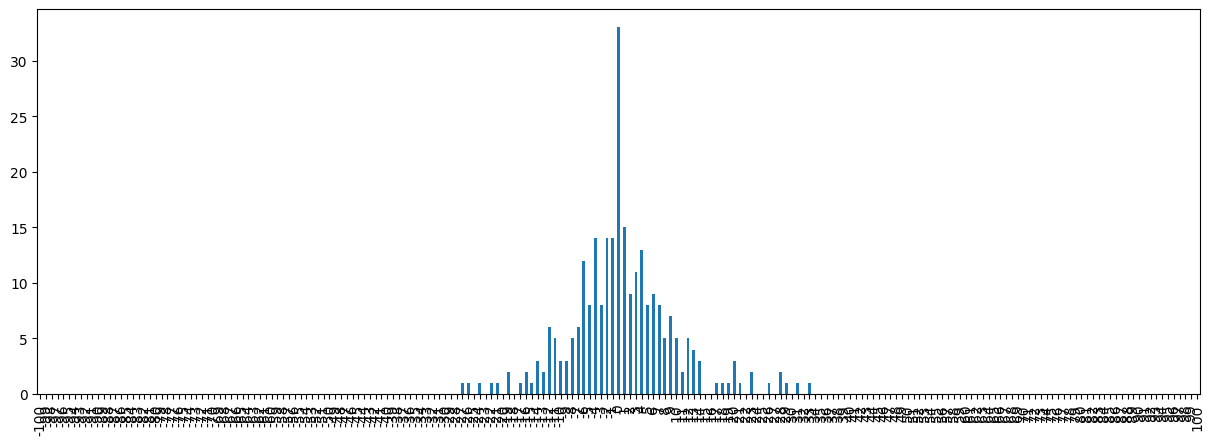

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# iperparametri
regKNN_params = {
    'n_neighbors': [3, 5, 9, 10, 15, 20, 30, 50],
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree', 'ball_tree']
}

# ricerca migliore configurazione di iperparametri
regKNN_grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=regKNN_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=False # lo faccio manualmente dopo
)
regKNN_grid.fit(X=X_TS, y=gt_y_TS)
regKNN_params_best = regKNN_grid.best_params_

# calcolo metriche
# lista adatta al ParameterGrid
regKNN_params_best = {k: [v] if not isinstance(v, list) else v for k, v in regKNN_params_best.items()}
regKNN_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=KNeighborsRegressor(),
                                    m_name="KNN",
                                    param_grid=ParameterGrid(regKNN_params_best),
                                    k=5,
                                    scaler=MinMaxScaler(),
                                    plot_err=True)

# >>>
print(f"{len(regKNN_perf)} model performance table available.")
regKNN_perf[0]


L'istogramma qui sopra presentato fa vedere come, se prendiamo in considerazione la migliore configurazione di iperparametri, nel momento in cui andiamo ad addestrare questo modello sui dati del TS e lo valutiamo sui dati del VS, il numero di esempi con errore percentuale 0% è di gran lunga maggiore rispetto a prima. Questo modello, inoltre, non fa errori gravi.

In [23]:
regKNN_grid.cv_results_

{'mean_fit_time': array([0.00479679, 0.0049964 , 0.00459709, 0.00399761, 0.00419736,
        0.00399737, 0.00359855, 0.00419693, 0.00399685, 0.00399671,
        0.00399723, 0.00379748, 0.00379705, 0.0035974 , 0.00339775,
        0.0039968 , 0.00279856, 0.00339789, 0.00319796, 0.00299783,
        0.0031981 , 0.003198  , 0.0031971 , 0.00319829, 0.00339813,
        0.00319667, 0.00339818, 0.00339794, 0.00339851, 0.00339932,
        0.00299845, 0.00319872]),
 'std_fit_time': array([7.48405504e-04, 1.09462594e-03, 4.89414904e-04, 5.09122765e-07,
        3.99828256e-04, 7.74768677e-07, 4.89960392e-04, 3.98734425e-04,
        4.26496120e-07, 4.15696997e-07, 2.86102295e-07, 3.99685162e-04,
        3.99351533e-04, 4.89512062e-04, 4.89453714e-04, 5.51978917e-07,
        3.99828028e-04, 4.89628956e-04, 3.99923481e-04, 3.81469727e-07,
        3.99732632e-04, 3.99661103e-04, 4.00352961e-04, 3.99637805e-04,
        4.89336913e-04, 4.00454744e-04, 4.89492864e-04, 4.89492725e-04,
        4.89222762e-0

### Regressore con Alberi di Decisione

I Regressori (e Classificatori) basati su Alberi di Decisione non necessitano di Feature Scaling perchè fanno scelte di partizionamento del DS basate su una soglia del dominio di una feature.

In [19]:
from sklearn.tree import DecisionTreeRegressor

# iperparametri
regDet_params = {
    'criterion': ['friedman_mse', 'squared_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 45, 90],
    'min_samples_leaf': [1, 5, 20, 50, 90],
    'min_samples_split': [2, 5, 10, 40, 60, 100, 150],
    'random_state': [1]
}

# ricerca migliore configurazione di iperparametri
regDet_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=regDet_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=False
)
regDet_grid.fit(X=X_TS, y=gt_y_TS)
regDet_params_best = regDet_grid.best_params_

# calcolo metriche
# lista adatta al ParameterGrid
regDet_params_best = {k: [v] if not isinstance(v, list) else v for k, v in regDet_params_best.items()}
regDet_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=DecisionTreeRegressor(random_state=1),
                                    m_name="Decision Tree",
                                    param_grid=ParameterGrid(regDet_params_best),
                                    k=5,
                                    scaler=None)

# >>>
print(f"{len(regDet_perf)} model performance table available.")
regDet_perf[0]

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['friedman_mse', 'squared_error',
                                       'poisson'],
                         'max_depth': [None, 5, 10, 15, 45, 90],
                         'min_samples_leaf': [1, 5, 20, 50, 90],
                         'min_samples_split': [2, 5, 10, 40, 60, 100, 150],
                         'random_state': [1], 'splitter': ['best', 'random']},
             refit=False, scoring='neg_mean_absolute_error')

1 model performance table available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
Decision Tree (Split 1),0.283006,0.149484,0.386631,0.283006,0.426087,0.283254,0.152299,0.390256,0.283254,0.393035
Decision Tree (Split 2),0.281740,0.143770,0.379170,0.281740,0.438627,0.317223,0.187674,0.433213,0.317223,0.302402
Decision Tree (Split 3),0.272543,0.141296,0.375893,0.272543,0.465469,0.288285,0.169364,0.411538,0.288285,0.282159
Decision Tree (Split 4),0.284372,0.146011,0.382114,0.284372,0.439113,0.295863,0.162391,0.402978,0.295863,0.353706
Decision Tree (Split 5),0.280766,0.143428,0.378719,0.280766,0.431873,0.305480,0.162462,0.403066,0.305480,0.428064
"Average ({'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 100, 'random_state': 1, 'splitter': 'random'})",0.280486,0.144798,0.380506,0.280486,0.440234,0.298021,0.166838,0.408210,0.298021,0.351873


In [24]:
regDet_grid.cv_results_

{'mean_fit_time': array([0.0283823 , 0.00899277, 0.02358451, ..., 0.00259819, 0.00599556,
        0.00239854]),
 'std_fit_time': array([7.98524495e-04, 1.37044028e-06, 1.01946822e-03, ...,
        4.89512619e-04, 6.32032740e-04, 4.89551003e-04]),
 'mean_score_time': array([0.001999  , 0.00180001, 0.00199962, ..., 0.00159907, 0.00159969,
        0.0015995 ]),
 'std_score_time': array([1.61421880e-06, 3.99804410e-04, 2.13248060e-07, ...,
        4.89687315e-04, 4.89609386e-04, 4.89941267e-04]),
 'param_criterion': masked_array(data=['friedman_mse', 'friedman_mse', 'friedman_mse', ...,
                    'poisson', 'poisson', 'poisson'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[None, None, None, ..., 90, 90, 90],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(d

### Regressore SVM

In [20]:
from sklearn.svm import SVR

# iperparametri
regSVR_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 15, 20, 100],
    'epsilon': [0.1, 0.2, 0.5, 1, 2],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}

# ricerca migliore configurazione di iperparametri
regSVR_grid = GridSearchCV(
    estimator=SVR(),
    param_grid=regSVR_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=False,
)
regSVR_grid.fit(X=X_TS, y=gt_y_TS)
regSVR_params_best = regSVR_grid.best_params_

# calcolo metriche
# lista adatta al ParameterGrid
regSVR_params_best = {k: [v] if not isinstance(v, list) else v for k, v in regSVR_params_best.items()}
regSVR_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=SVR(),
                                    m_name="SVR",
                                    param_grid=ParameterGrid(regSVR_params_best),
                                    k=5,
                                    scaler=MinMaxScaler())

# >>>
print(f"{len(regSVR_perf)} model performance table available.")
regSVR_perf[0]

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 15, 20, 100],
                         'epsilon': [0.1, 0.2, 0.5, 1, 2],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             refit=False, scoring='neg_mean_absolute_error')

1 model performance table available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
SVR (Split 1),0.277744,0.137739,0.371133,0.277744,0.471177,0.286436,0.143856,0.379284,0.286436,0.426685
SVR (Split 2),0.272504,0.133122,0.364860,0.272504,0.480203,0.317412,0.180146,0.424436,0.317412,0.330385
SVR (Split 3),0.274111,0.130328,0.361010,0.274111,0.506960,0.312163,0.185892,0.431152,0.312163,0.212105
SVR (Split 4),0.280458,0.138716,0.372446,0.280458,0.467137,0.287340,0.152116,0.390021,0.287340,0.394598
SVR (Split 5),0.270307,0.130182,0.360807,0.270307,0.484341,0.315469,0.172161,0.414923,0.315469,0.393921
"Average ({'C': 20, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'})",0.275025,0.134018,0.366051,0.275025,0.481964,0.303764,0.166834,0.407963,0.303764,0.351539


### Regressore Random Forest

Il regressore Random Forest rientra tra le tecniche Ensemble di SL. A partire da un TS, addestra più alberi di regressione, tenendo conto che ciascun albero può basarsi su una partizione del TS originale diversa da quella di un altro albero. Una volta che tutti gli alberi hanno predetto un valore, la tecnica Random Forest restituisce un valore ottenuto dalla combinazione dei precedenti.

In [26]:
regSVR_grid.cv_results_

{'mean_fit_time': array([0.03537803, 0.05776372, 0.05816321, 0.05776401, 0.05776367,
        0.05756335, 0.02898135, 0.05136766, 0.04916892, 0.05096774,
        0.05356712, 0.05216827, 0.01419148, 0.02638421, 0.02618346,
        0.02618308, 0.02598381, 0.02658353, 0.00339775, 0.00379715,
        0.00399804, 0.00399718, 0.00399747, 0.00379748, 0.00259852,
        0.00240002, 0.00219851, 0.00279827, 0.00239887, 0.00239835,
        0.03597689, 0.06595883, 0.06715817, 0.06795754, 0.06735868,
        0.06855736, 0.03098063, 0.06216135, 0.06076241, 0.06136208,
        0.06096268, 0.06076226, 0.01559043, 0.03118105, 0.02958164,
        0.03098106, 0.03138108, 0.03198056, 0.00379767, 0.00459728,
        0.00459728, 0.0043972 , 0.00459728, 0.00459728, 0.00259867,
        0.00219798, 0.00239811, 0.00239854, 0.00219855, 0.00239835,
        0.04557085, 0.06855764, 0.06815805, 0.06835914, 0.06875706,
        0.06855717, 0.04277439, 0.06236076, 0.0639596 , 0.06475954,
        0.06855745, 0.06176124,

In [21]:
from ensurepip import bootstrap
from sklearn.ensemble import RandomForestRegressor

# iperparametri
regRaF_params = {
    'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [50, 100],
    'max_depth': [10, 15, 22],
    'min_samples_leaf': [1, 5, 20],
    'min_samples_split': [2, 50, 120],
    'random_state': [66],
    'bootstrap': [True]
}

# ricerca migliore configurazione di iperparametri
regRaF_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=regRaF_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=False,
)
regRaF_grid.fit(X=X_TS, y=gt_y_TS)
regRaF_params_best = regRaF_grid.best_params_

# calcolo metriche
# lista adatta al ParameterGrid
regRaF_params_best = {k: [v] if not isinstance(v, list) else v for k, v in regRaF_params_best.items()}
regRaF_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=RandomForestRegressor(random_state=66),
                                    m_name="Random Forest",
                                    param_grid=ParameterGrid(regRaF_params_best),
                                    k=5,
                                    scaler=None)

# >>>
print(f"{len(regRaF_perf)} model performance table available.")
regRaF_perf[0]



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True],
                         'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [10, 15, 22],
                         'min_samples_leaf': [1, 5, 20],
                         'min_samples_split': [2, 50, 120],
                         'n_estimators': [50, 100], 'random_state': [66]},
             refit=False, scoring='neg_mean_absolute_error')

1 model performance table available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
Random Forest (Split 1),0.222861,0.089397,0.298993,0.222861,0.656778,0.258651,0.123710,0.351724,0.258651,0.506974
Random Forest (Split 2),0.223662,0.088572,0.297611,0.223662,0.654157,0.272727,0.139801,0.373900,0.272727,0.480347
Random Forest (Split 3),0.223498,0.090239,0.300398,0.223498,0.658619,0.274726,0.141813,0.376581,0.274726,0.398929
Random Forest (Split 4),0.223498,0.089762,0.299603,0.223498,0.655188,0.266737,0.131511,0.362644,0.266737,0.476605
Random Forest (Split 5),0.218932,0.084735,0.291093,0.218932,0.664357,0.287915,0.148742,0.385670,0.287915,0.476367
"Average ({'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 66})",0.222490,0.088541,0.297540,0.222490,0.657820,0.272151,0.137115,0.370104,0.272151,0.467845


### Regressore Gradient Boosting

Il regressore Gradient Boosting rientra anch'esso tra le tecniche Ensemble di SL, ma, a differenza del Random Forest, usa un approccio di boosting, cioè crea un nuovo albero di decisione sulla base degli esiti ottenuti dell'albero precedente.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

regGrB_params = {
    'criterion': ['friedman_mse'],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.5],
    'max_depth': [10, 22],
    'min_samples_leaf': [1, 5, 20],
    'min_samples_split': [2, 50, 120],
    'random_state': [66]
}

# ricerca migliore configurazione di iperparametri
regGrB_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=regGrB_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=False,
)
regGrB_grid.fit(X=X_TS, y=gt_y_TS)
regGrB_params_best = regGrB_grid.best_params_

# calcolo metriche
# lista adatta al ParameterGrid
regGrB_params_best = {k: [v] if not isinstance(v, list) else v for k, v in regGrB_params_best.items()}
regGrB_perf = kfold_cv_w_err_penalty(X=X_DS_, y=y_DS_,
                                    m=GradientBoostingRegressor(random_state=66),
                                    m_name="Random Forest",
                                    param_grid=ParameterGrid(regGrB_params_best),
                                    k=5,
                                    scaler=None)

# >>>
print(f"{len(regGrB_perf)} model performance table available.")
regGrB_perf[0]

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.05, 0.1, 0.5],
                         'max_depth': [10, 22], 'min_samples_leaf': [1, 5, 20],
                         'min_samples_split': [2, 50, 120],
                         'n_estimators': [50, 100], 'random_state': [66]},
             refit=False, scoring='neg_mean_absolute_error')

1 model performance table available.


,MAE (TS),MSE (TS),RMSE (TS),MAPE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),MAPE (TE),R^2 (TE)
Random Forest (Split 1),0.197144,0.070473,0.265468,0.197144,0.729433,0.266371,0.129938,0.360470,0.266371,0.482152
Random Forest (Split 2),0.196401,0.069103,0.262875,0.196401,0.730176,0.266252,0.135274,0.367796,0.266252,0.497177
Random Forest (Split 3),0.194121,0.067305,0.259432,0.194121,0.745382,0.279475,0.148420,0.385253,0.279475,0.370928
Random Forest (Split 4),0.199567,0.070689,0.265874,0.199567,0.728455,0.268259,0.137173,0.370369,0.268259,0.454071
Random Forest (Split 5),0.195526,0.069211,0.263080,0.195526,0.725850,0.287722,0.146801,0.383147,0.287722,0.483197
"Average ({'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 120, 'n_estimators': 50, 'random_state': 66})",0.196552,0.069356,0.263346,0.196552,0.731859,0.273616,0.139521,0.373407,0.273616,0.457505


In [27]:
regGrB_grid.cv_results_

{'mean_fit_time': array([1.0601439 , 2.13246984, 0.78471522, 1.61640034, 0.67518229,
        1.44450669, 0.831285  , 1.76930709, 0.74094138, 1.5416471 ,
        0.63160944, 1.3847436 , 0.55905457, 1.23223839, 0.54726171,
        1.21684761, 0.47630515, 1.09952054, 1.51886163, 3.04471731,
        1.07813334, 2.53882914, 0.84647908, 2.07991362, 1.04855175,
        2.56741261, 0.93762054, 2.33155832, 0.72415247, 1.94439931,
        0.60342774, 1.4620944 , 0.58044162, 1.45530005, 0.5252749 ,
        1.27661066, 1.06893821, 2.09090719, 0.81969266, 1.64198503,
        0.7469378 , 1.52185931, 0.86126733, 1.74632301, 0.77112317,
        1.62839332, 0.71555896, 1.4718883 , 0.63840446, 1.32957807,
        0.61981554, 1.31658597, 0.55405579, 1.20265675, 1.54463339,
        3.0780972 , 1.26221805, 2.83984442, 1.04215546, 2.32875996,
        1.28840332, 2.96516633, 1.16268106, 2.70112982, 1.00697789,
        2.25040827, 0.73574333, 1.71533937, 0.70836124, 1.64698172,
        0.63001003, 1.4315146 ,